In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/msk_2024_fe_15.csv')

In [3]:
# locate the columns index for OS_MONTHS
os_months_index = df.columns.get_loc("OS_MONTHS")
df.iloc[:, os_months_index:os_months_index + 3].head(5)

,OS_MONTHS,OS_STATUS,highest_stage_recorded
0,13.906834,1,0
1,115.462887,0,1
2,13.610944,1,0
3,60.756098,1,1
4,29.621885,1,1


In [4]:
# data preprocessing, remove patien id and OS_MONTHS
df = df.drop(columns=['Patient'])
X = df.drop(columns=['OS_STATUS'])
y = df['OS_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([17827, 981]) torch.Size([17827])


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from lifelines.utils import concordance_index # c-index for optimization, do we need to use this?

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim2)
        self.dropout3 = nn.Dropout(dropout)
        
        self.out = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.out(x)
        return x.squeeze(-1)

In [6]:
input_dim = X_train.shape[1]
model = MLP(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = nn.MSELoss()

epochs = 100
train_loss = []
val_loss = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test)
        val_loss_value = loss_fn(y_val_pred, y_test)
        val_loss.append(val_loss_value.item())
        train_loss.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        print(f'Validation Loss: {val_loss_value.item():.4f}')

Epoch [10/100], Loss: 0.3627
Validation Loss: 0.4225
Epoch [20/100], Loss: 0.2688
Validation Loss: 0.3057
Epoch [30/100], Loss: 0.2398
Validation Loss: 0.2383
Epoch [40/100], Loss: 0.2222
Validation Loss: 0.1918
Epoch [50/100], Loss: 0.2020
Validation Loss: 0.1797
Epoch [60/100], Loss: 0.1889
Validation Loss: 0.1744
Epoch [70/100], Loss: 0.1757
Validation Loss: 0.1701
Epoch [80/100], Loss: 0.1708
Validation Loss: 0.1664
Epoch [90/100], Loss: 0.1642
Validation Loss: 0.1693
Epoch [100/100], Loss: 0.1552
Validation Loss: 0.1688


In [ ]:
# CNN implementation

In [ ]:
# LSTM implementation

In [ ]:
# ResNet implementation

In [ ]:
# Transformer implementation

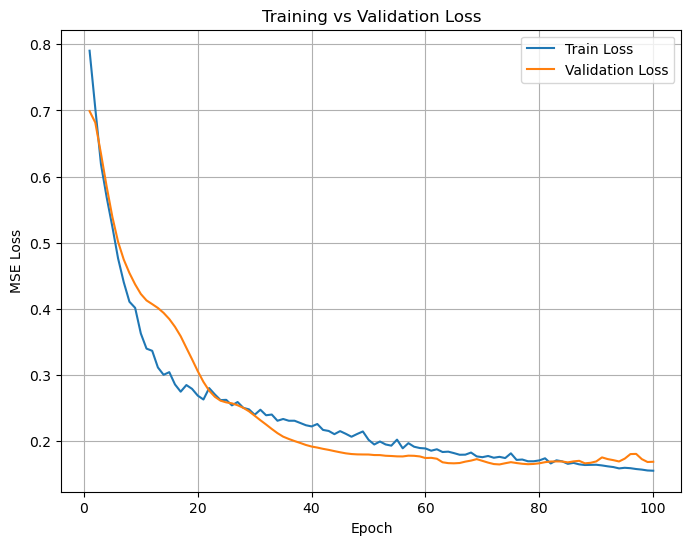

In [7]:
import os
save_path = '../../results/dvd_basicML'
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, 'mlp_loss.png'))
plt.show()